Notebook to determine the stellar mass limits that should be imposed on the $100\,\mathrm{Myr}$ averaged SFRs due to reslution limits of the simulations. The idea is to combine "theoretical" limits based on SFR resolution and also 

In [3]:
import numpy as np 
# -- local -- 
import env
import util as UT
import catalogs as Cats
from fstarforms import fstarforms
from scipy.stats import multivariate_normal as MNorm

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

the SFR resolutions of the catalogs

In [5]:
def dSFR_catalog(cat_name): 
    if cat_name not in ['illustris_100myr', 'eagle_100myr', 'mufasa_100myr']: 
        raise ValueError
    elif cat_name == 'illustris_100myr': 
        dsfr = 0.016
    elif cat_name == 'eagle_100myr': 
        dsfr = 0.018
    elif cat_name == 'mufasa_100myr': 
        dsfr = 0.182
    return dsfr

Conservative limits set by when the maximum SFR limit of $\widehat{\mathrm{SFR}} = 0$ 

(-13.0, -8.5)

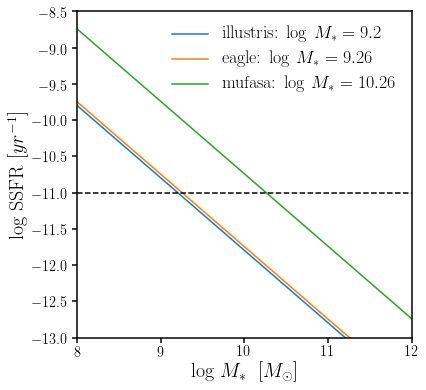

In [6]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
logm = np.linspace(8.,12., 40)
for cat in ['illustris_100myr', 'eagle_100myr', 'mufasa_100myr']: 
    mlim = 11. + np.log10(dSFR_catalog(cat))
    sub.plot(logm, np.log10(dSFR_catalog(cat)) - logm, 
             label=cat.split('_')[0]+': $\log\,M_*='+str(round(mlim,2))+'$')
sub.plot([8., 12.], [-11., -11.], c='k', ls='--')    

sub.legend(loc='upper right', prop={'size':18})
sub.set_xlabel(r'log $M_* \;\;[M_\odot]$', fontsize=20)
sub.set_xlim([8., 12.])
sub.set_ylabel(r'log SSFR $[yr^{-1}]$', fontsize=20)
sub.set_ylim([-13., -8.5])

In [7]:
def Catalog_wo_scatter(cat_name): 
    ''' Read in log M* and log SFR of central galaxies and resample their SFRs within the bound set by
    the resolution limit
    '''
    dsfr = dSFR_catalog(cat_name)

    Cat = Cats.Catalog()
    _logM, _logSFR, w, censat = Cat.Read(cat_name, keepzeros=True, silent=True)
    iscen = ((censat == 1) & np.invert(Cat.zero_sfr))
    return _logM[iscen], _logSFR[iscen]

In [8]:
def Catalog_w_scatter(cat_name): 
    ''' Read in log M* and log SFR of central galaxies and resample their SFRs within the bound set by
    the resolution limit
    '''
    dsfr = dSFR_catalog(cat_name)

    Cat = Cats.Catalog()
    _logM, _logSFR, w, censat = Cat.Read(cat_name, keepzeros=True, silent=True)
    iscen_nz = (censat == 1) & np.invert(Cat.zero_sfr)
    iscen_z = (censat == 1) & Cat.zero_sfr
    assert np.sum(censat == 1) == np.sum(iscen_nz) + np.sum(iscen_z)
    _SFR = 10**_logSFR

    sfr_low = _SFR[iscen_nz] - dsfr
    sfr_low[sfr_low <= 0.] = 0. 
    logsfr_nz = np.log10(np.random.uniform(sfr_low, _SFR[iscen_nz]+dsfr, size=np.sum(iscen_nz)))
    logsfr_z = np.log10(dsfr * np.random.uniform(size=np.sum(iscen_z)))

    logm = np.concatenate([_logM[iscen_nz], _logM[iscen_z]])
    logsfr = np.concatenate([logsfr_nz, logsfr_z])
    return logm, logsfr

In [9]:
def gmm_pdf(xx, gmm, icomp): 
    return gmm.weights_[icomp]*MNorm.pdf(xx, gmm.means_.flatten()[icomp], gmm.covariances_.flatten()[icomp])

In [29]:
def plot_gmmfit_impact(cat):
    mlim = np.ceil((11. + np.log10(dSFR_catalog(cat)))/0.2) * 0.2 # conservative mass limit
    # without scatter
    logm, logsfr = Catalog_wo_scatter(cat)
    fSFMS = fstarforms()
    fit_logm, fit_logsfr = fSFMS.fit(logm, logsfr, method='gaussmix', 
                                     dlogm=0.2, fit_range=[8.,mlim], maxcomp=3, forTest=True) 
    # with scatter
    logm_scat, logsfr_scat = Catalog_w_scatter(cat)
    fSFMS_scat = fstarforms()
    fit_logm_s, fit_logsfr_s = fSFMS_scat.fit(logm_scat, logsfr_scat, method='gaussmix', 
                                     dlogm=0.2, fit_range=[8.,mlim], maxcomp=4, forTest=True) 
    
    n_col = int(np.ceil(float(len(fit_logm))/2))
    fig = plt.figure(figsize=(5*n_col, 8))
    bkgd = fig.add_subplot(111, frameon=False)
    
    mbin_mid = fSFMS._tests['mbin_mid']
    gbests = fSFMS._tests['gbests']
    gbests_scat = fSFMS_scat._tests['gbests']
    dlogm = fSFMS._dlogm
    assert len(mbin_mid) == len(fit_logm)    
    assert np.array_equal(mbin_mid, fSFMS_scat._tests['mbin_mid'])
    
    f_nzs = [] 
    for i_m in range(len(mbin_mid)): 
        sub = fig.add_subplot(2, n_col, i_m+1)
        in_mbin_nz = (logm > mbin_mid[i_m]-0.5*dlogm) & (logm < mbin_mid[i_m]+0.5*dlogm)
        in_mbin = (logm_scat > mbin_mid[i_m]-0.5*dlogm) & (logm_scat < mbin_mid[i_m]+0.5*dlogm)
        # fraction of galaxies w/ SFR != 0 
        f_nz = float(np.sum(in_mbin_nz))/float(np.sum(in_mbin)) 
        f_nzs.append(f_nz)

        h0s, h1s = np.histogram(logsfr_scat[in_mbin] - logm_scat[in_mbin], bins=40, range=[-15., -8.])
        xx, yy = UT.bar_plot(h1s, h0s/np.diff(h1s)[0]/h0s.sum())
        sub.fill_between(xx, np.zeros(len(yy)), yy, color='C1', alpha=0.25)#, lw=1)
        
        h0, h1 = np.histogram(logsfr[in_mbin_nz] - logm[in_mbin_nz], bins=40, range=[-15., -8.])
        xx, yy = UT.bar_plot(h1, h0/np.diff(h1)[0]/h0s.sum())
        sub.fill_between(xx, np.zeros(len(yy)), yy, color='k', alpha=0.25)#, lw=1)
        
        # plot the fits 
        xx = np.linspace(-14, -8, 100) 
        # sfms component of SFR without scatter
        i_comp = (gbests[i_m].means_.flatten() == fit_logsfr[i_m] - fit_logm[i_m])
        sub.plot(xx, f_nz*gmm_pdf(xx, gbests[i_m], i_comp), c='C0', lw=2, ls='--', label='GMM w/o scatter')
        # other components
        for i_c in np.arange(len(gbests[i_m].weights_))[(gbests[i_m].means_.flatten() != fit_logsfr[i_m] - fit_logm[i_m])]: 
            sub.plot(xx, f_nz*gmm_pdf(xx, gbests[i_m], i_c), c='C0', lw=2, ls=':')
        # sfms component of SFR w scatter
        i_comp = (gbests_scat[i_m].means_.flatten() == fit_logsfr_s[i_m] - fit_logm_s[i_m])
        sub.plot(xx, gmm_pdf(xx, gbests_scat[i_m], i_comp), c='C3', lw=2, ls='--', label='GMM w/ scatter')
        # other components of SFR w scatter
        for i_c in np.arange(len(gbests_scat[i_m].weights_))[(gbests_scat[i_m].means_.flatten() != fit_logsfr_s[i_m] - fit_logm_s[i_m])]: 
            sub.plot(xx, gmm_pdf(xx, gbests_scat[i_m], i_c), c='C3', lw=2, ls=':')   
        if i_m == 0: 
            sub.legend(bbox_to_anchor=(0.725, 0.875), prop={'size':15})
        sub.vlines(np.log10(dSFR_catalog(cat)) - mbin_mid[i_m], 0., 2., linestyle=':')
        # x-axis
        sub.set_xlim([-13, -8])
        sub.set_xticks([-13, -12, -11, -10, -9, -8])
        sub.set_ylim([0., 2.])
        sub.set_yticks([0., 1., 2.])
        # indicate stellar mass bin 
        sub.text(0.5, 0.9, 
                str(round(mbin_mid[i_m]-0.5*dlogm,1))+'$<$ log$\,M_* <$'+str(round(mbin_mid[i_m]+0.5*dlogm,1)), 
                ha='center', va='center', transform=sub.transAxes, fontsize=20)
    bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    bkgd.set_ylabel(r'P(log SSFR  $[yr^{-1}])$', labelpad=20, fontsize=30) 
    bkgd.set_xlabel(r'log SSFR  $[yr^{-1}]$', labelpad=20, fontsize=30) 
    fig.subplots_adjust(hspace=0.15, wspace=0.15)
    
    fig2 = plt.figure(2, figsize=(4,4))
    sub = fig2.add_subplot(111)
    sub.plot(mbin_mid, 1.-np.array(f_nzs))
    sub.set_xlabel(r'log $M_* \;\;[M_\odot]$', fontsize=20)
    sub.set_xlim([8., 12.])
    sub.set_ylabel(r'$f_{SFR=0}$', fontsize=20)
    sub.set_ylim([0., 1.])
    plt.show()

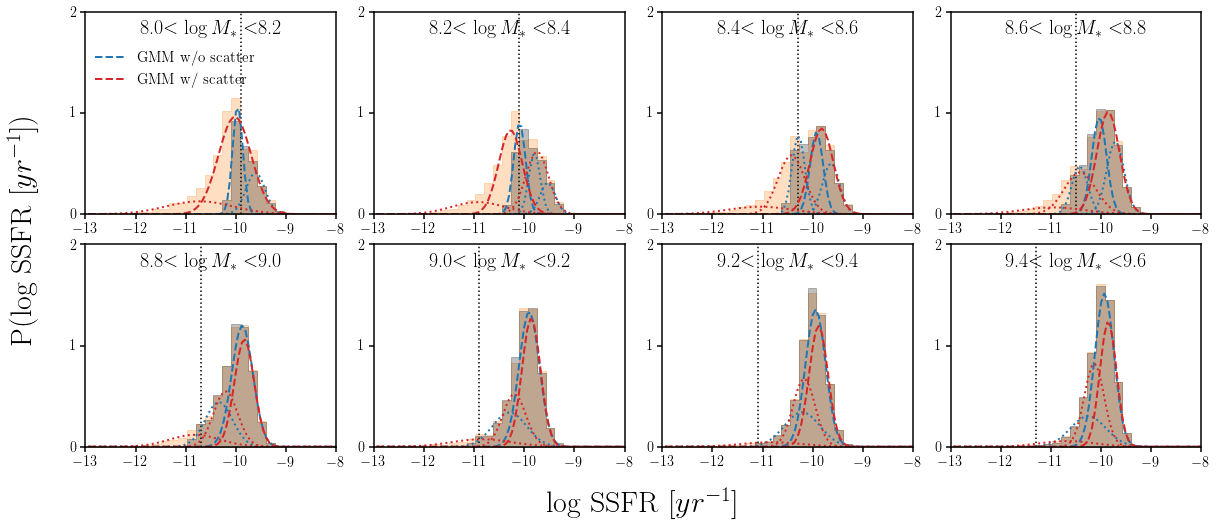

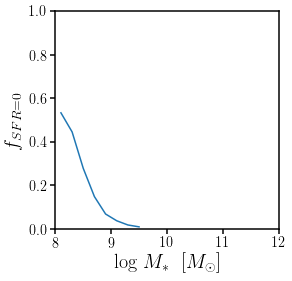

In [30]:
plot_gmmfit_impact('illustris_100myr')

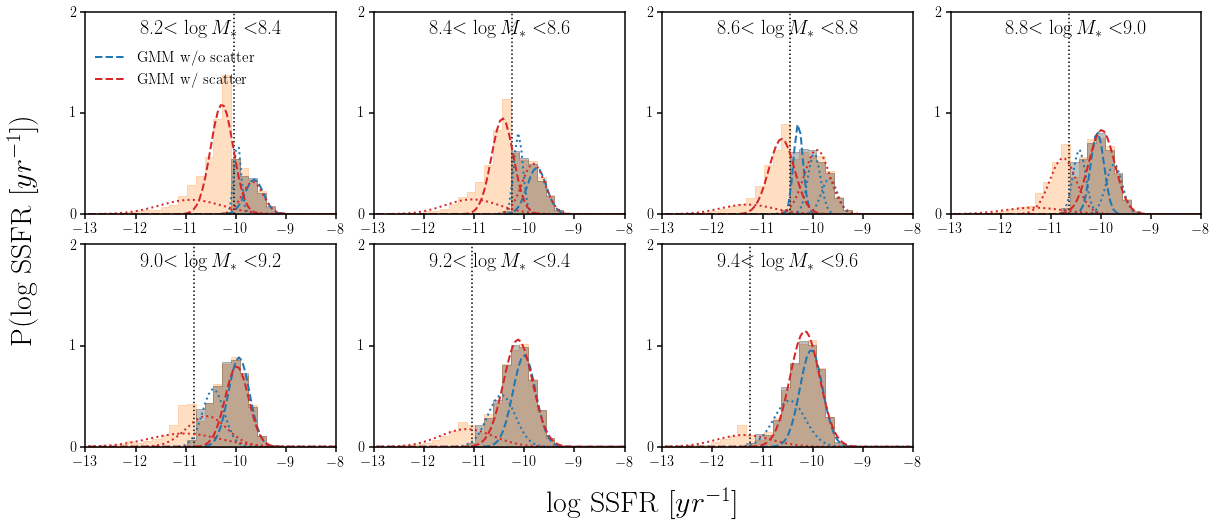

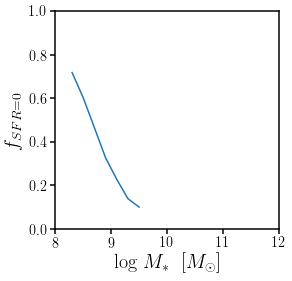

In [31]:
plot_gmmfit_impact('eagle_100myr')

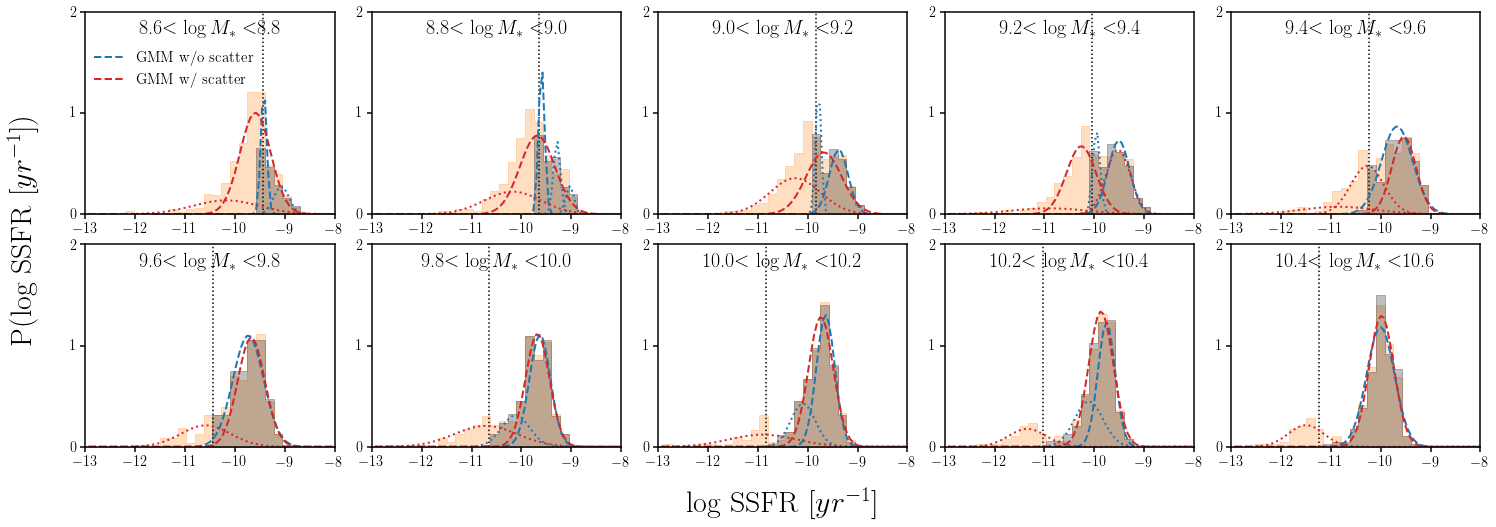

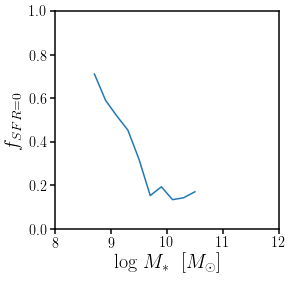

In [32]:
plot_gmmfit_impact('mufasa_100myr')

In [39]:
def plot_gmmfit_sfrmstar(cat, n_mc=100):
    # without scatter
    logm, logsfr = Catalog_wo_scatter(cat)
    fSFMS = fstarforms()
    fit_logm, fit_logsfr = fSFMS.fit(logm, logsfr, method='gaussmix', 
                                     dlogm=0.2, fit_range=[8.,11.], maxcomp=3, 
                                     forTest=True, silent=True) 
    # with scatter
    fit_logsfr_s = []
    for i in range(n_mc): 
        logm_scat, logsfr_scat = Catalog_w_scatter(cat)
        fSFMS_scat = fstarforms()
        fit_logm_s, fit_logsfr_s_i = fSFMS_scat.fit(logm_scat, logsfr_scat, method='gaussmix', 
                                                  dlogm=0.2, fit_range=[8.,11.], maxcomp=4, 
                                                    forTest=True, silent=True) 
        fit_logsfr_s.append(fit_logsfr_s_i)
    sig_fit_logsfr_s = np.std(np.array(fit_logsfr_s), axis=0)   
    fit_logsfr_s = np.mean(fit_logsfr_s, axis=0)

    # check that the mbins are equal
    assert np.array_equal(fSFMS._tests['mbin_mid'], fSFMS_scat._tests['mbin_mid'])
    dfit = np.array(fit_logsfr) - np.array(fit_logsfr_s)
    # mass where resolution limit causes the SFMS to shift by 0.1 dex
    mbin_mid = np.array(fSFMS._tests['mbin_mid'])
    mlim = (mbin_mid[(np.abs(dfit) > 0.1)]).max() + 0.5*fSFMS._dlogm 
    
    fig = plt.figure(figsize=(4,4))
    bkgd = fig.add_subplot(111, frameon=False)
    sub = fig.add_subplot(111)
    sub.scatter(fit_logm, fit_logsfr, marker='x', color='k', lw=1, s=40)
    sub.scatter(fit_logm_s, fit_logsfr_s, marker='x', color='C1', lw=1, s=40)
    
    sub.text(0.5, 0.92, '$\log\,M_{\lim}='+str(round(mlim,2))+'$', 
             ha='center', va='top', transform=sub.transAxes, fontsize=15)
    sub.vlines(mlim, -4., 2., color='k')
    bkgd.set_xlabel(r'log $M_* \;\;[M_\odot]$', labelpad=10, fontsize=25) 
    sub.set_xlim([8., 12.])
    bkgd.set_ylabel(r'log SFR $[M_\odot \, yr^{-1}]$', labelpad=10, fontsize=25) 
    sub.set_ylim([-4., 2.])
    bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    fig.subplots_adjust(hspace=0.15, wspace=0.15)
    plt.show()

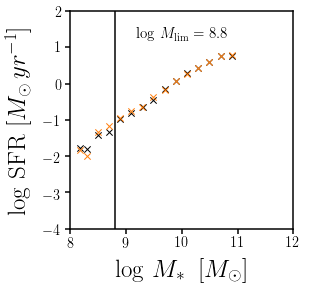

In [40]:
plot_gmmfit_sfrmstar('illustris_100myr')

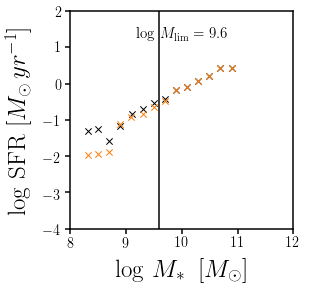

In [41]:
plot_gmmfit_sfrmstar('eagle_100myr')

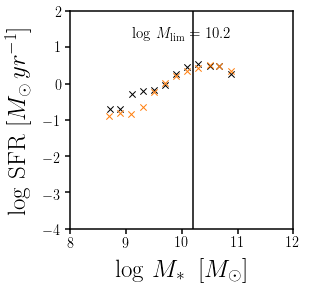

In [42]:
plot_gmmfit_sfrmstar('mufasa_100myr')

In [45]:
def Mlim_res(cat, n_mc=100):
    mlim_theory = np.ceil((11. + np.log10(dSFR_catalog(cat)))/0.1)*0.1# conservative mass limit
    # without scatter
    logm, logsfr = Catalog_wo_scatter(cat)
    fSFMS = fstarforms()
    fit_logm, fit_logsfr = fSFMS.fit(logm, logsfr, method='gaussmix', 
                                     dlogm=0.2, fit_range=[8.,11.], maxcomp=3, 
                                     forTest=True, silent=True) 
    # with scatter
    fit_logsfr_s = []
    for i in range(n_mc): 
        logm_scat, logsfr_scat = Catalog_w_scatter(cat)
        fSFMS_scat = fstarforms()
        fit_logm_s, fit_logsfr_s_i = fSFMS_scat.fit(logm_scat, logsfr_scat, method='gaussmix', 
                                                    dlogm=0.2, fit_range=[8.,11.], maxcomp=4, 
                                                    forTest=True, silent=True) 
        fit_logsfr_s.append(fit_logsfr_s_i)
    sig_fit_logsfr_s = np.std(np.array(fit_logsfr_s), axis=0)   
    fit_logsfr_s = np.mean(fit_logsfr_s, axis=0)

    # check that the mbins are equal
    assert np.array_equal(fSFMS._tests['mbin_mid'], fSFMS_scat._tests['mbin_mid'])
    dfit = np.array(fit_logsfr) - np.array(fit_logsfr_s)
    # mass where resolution limit causes the SFMS to shift by 0.1 dex
    mbin_mid = np.array(fSFMS._tests['mbin_mid'])
    mlim = (mbin_mid[(np.abs(dfit) > 0.1)]).max() + 0.5*fSFMS._dlogm 
    print mlim, mlim_theory
    return np.max([mlim, mlim_theory])

In [46]:
for name in ['illustris_100myr', 'eagle_100myr', 'mufasa_100myr']:
    print name, Mlim_res(name)

illustris_100myr 8.8 9.3
9.3
eagle_100myr 9.6 9.3
9.6
mufasa_100myr 10.2 10.3
10.3
